# 2022 UOS Big Data Algorithm Competition

## Hyperparameter Tuning and Regularization for Time Series Model Using Prophet in Python

### Reference URL:
- https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc

### What we learn:
- What are the hyperparameters for a prophet time series model?


- Among all the hyperparameters, what hyperparameters should be tuned, and what hyperparameters are better not to be tuned?


- Among all the hyperparameters that should be tuned, what hyperparameters should be tuned automatically vs. manually?


- How are hyperparameter tunings related to regularization?


- How does data transformation impact the model performance?

### For begineer:
#### Reference URL:
- https://medium.com/grabngoinfo/time-series-forecasting-of-bitcoin-prices-using-prophet-1069133708bc


- https://medium.com/grabngoinfo/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57



- https://medium.com/grabngoinfo/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9

<br>

## Step 0. Overview of All the Hyperparameters for a Prophet Model

#### 하이퍼 파라미터는 크게 세 그룹으로 나뉘어짐
1. The first group contains hyperparameters that are suitable for automatic tuning. We can specify a list of values and do a grid search for the best value combination. For more information about grid search, please refer to my previous tutorial Hyperparameter Tuning For XGBoost


##### XGBoost:
- https://pub.towardsai.net/lasso-l1-vs-ridge-l2-vs-elastic-net-regularization-for-classification-model-409c3d86f6e9

<br>

2. The second group contains hyperparameters that are suitable for manual tuning. A human needs to make a judgment on what hyperparameter value to use based on knowledge about data and business.

<br>

3. The third group contains the hyperparameters that are better left untuned with the default values.

### Group 1: Hyperparameters Suitable for Automatic Tuning

- 그리드 서치를 통해서 자동 튜닝할 수 있는 하이퍼파라미터는 네 가지!!


    - changepoint_prior_scale 
    (Most impactful parameter, default=0.05, 0.001~0.5, log_scale)

    - seasonality_prior_scale 
    (L2 Ridge regularization, default=10, recommended=0.01~10, log_scale)

    - holidays_prior_scale 
    (default=10, recommended=0.01~10)

    - seasonality_mode 
    (two_options=[additive, multiplicative])
    


### Group 2: Hyperparameters Suitbale for Manual Tuning

- Business knowledge 또는 data observations를 통한 human-based 튜닝이 필요한 요소들


- 디테일하게 7가지


    - changepoint_range
    (value=0~1, default=0.8)
    
    - growth
    (two_options=[linear, logistic], default=linear, knowning growth saturating point > logistic)
    
    - changepoints
    (default=None)
    
    - yearly_seaonality
    (three_options=[auto, True, False], default=auto)
    
    - weekly_seasonality, daily_seasonality
    (yearly_seasonality와 동일한 방식으로 설정 가능)
    
    - holidays
    (special day > manually include or exclude holidays or events)
    
    

### Group 3: Hyperparameters Suitable for No Tuning

- 튜닝하면 안되는 다섯 가지 요소!
    
    
    - n_changepoints
    (default=25, 해당 데이터의 수정보다는 changepoint_prior_scale을 수정하자!)
    
    - interval_width
    (default=0.8, yhat_upper 및 yhat_lower 값이 80%의 불확실성 주기를 갖고 있다는 의미, 값을 변경해도 큰 의미 X)
    
    - uncertainty_samples
    (default=1000)
    
    - mcmc_samples
    (Bayesian inference[샘플>0] or Maximum a Posterior (MAP)[샘플=0], default_mcmc_samples=0)
    
    - stan_backend
    (pystan and cmdstanpy 값에 대한 선택, 변경에 따른 이득 X)

<br>

## Step 1. Install and Import Libraries

In [1]:
# import module
# The Four Musketeers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

<br>

## Step 2. Pull Data

In [3]:
!ls

UOS_2022.ipynb                        submission_11-14-2022 19:28:33 PM.csv
UOS_2022_custom.ipynb                 submission_11-14-2022 19:31:33 PM.csv
dacon_236029_open                     submission_11-14-2022 21:02:11 PM.csv
dacon_236029_open.zip                 train_all.csv
result                                train_test_all_2.numbers


In [4]:
train = pd.read_csv('./dacon_236029_open/train.csv')
# train

In [5]:
sample = pd.read_csv('./dacon_236029_open/sample_submission.csv')
# sample

In [6]:
# Date start date
start_date = '2018-01-01'

# Date end date
end_date = '2021-12-31'

#### Prophet requires at least two columns as inputs: a ds column and a y column.

##### ds 컬럼에는 시간 정보 포함

- 위의 경우에서는 date를 ds로 reset index & rename 작업 진행

<br>

##### y 컬럼에는 시계열값 포함

- 위의 경우에서는 따릉이 예상 사용량이 y로 표현

In [ ]:
# datatime 포맷으로 변경
train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d')
# train

# 향후 사용 예정
# territory_list = ['광진구', '동대문구', '성동구', '중랑구'] > ['g', 'd', 's', 'j']

In [15]:
# 광진구의 경우 > df_g
df = pd.DataFrame(train)
# df

df_g = df[['일시', '광진구']]
df_g

,일시,광진구
0,2018-01-01,0.592
1,2018-01-02,0.840
2,2018-01-03,0.828
3,2018-01-04,0.792
4,2018-01-05,0.818
...,...,...
1456,2021-12-27,3.830
1457,2021-12-28,4.510
1458,2021-12-29,4.490
1459,2021-12-30,4.444


In [19]:
# 광진구 컬럼 이름 변경 to ds & y
# df_g.columns
df_g.columns = ['ds', 'y']
df_g

,ds,y
0,2018-01-01,0.592
1,2018-01-02,0.840
2,2018-01-03,0.828
3,2018-01-04,0.792
4,2018-01-05,0.818
...,...,...
1456,2021-12-27,3.830
1457,2021-12-28,4.510
1458,2021-12-29,4.490
1459,2021-12-30,4.444


In [20]:
# 광진구 데이터 확인
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1461 non-null   datetime64[ns]
 1   y       1461 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.0 KB


### Semi Visualization

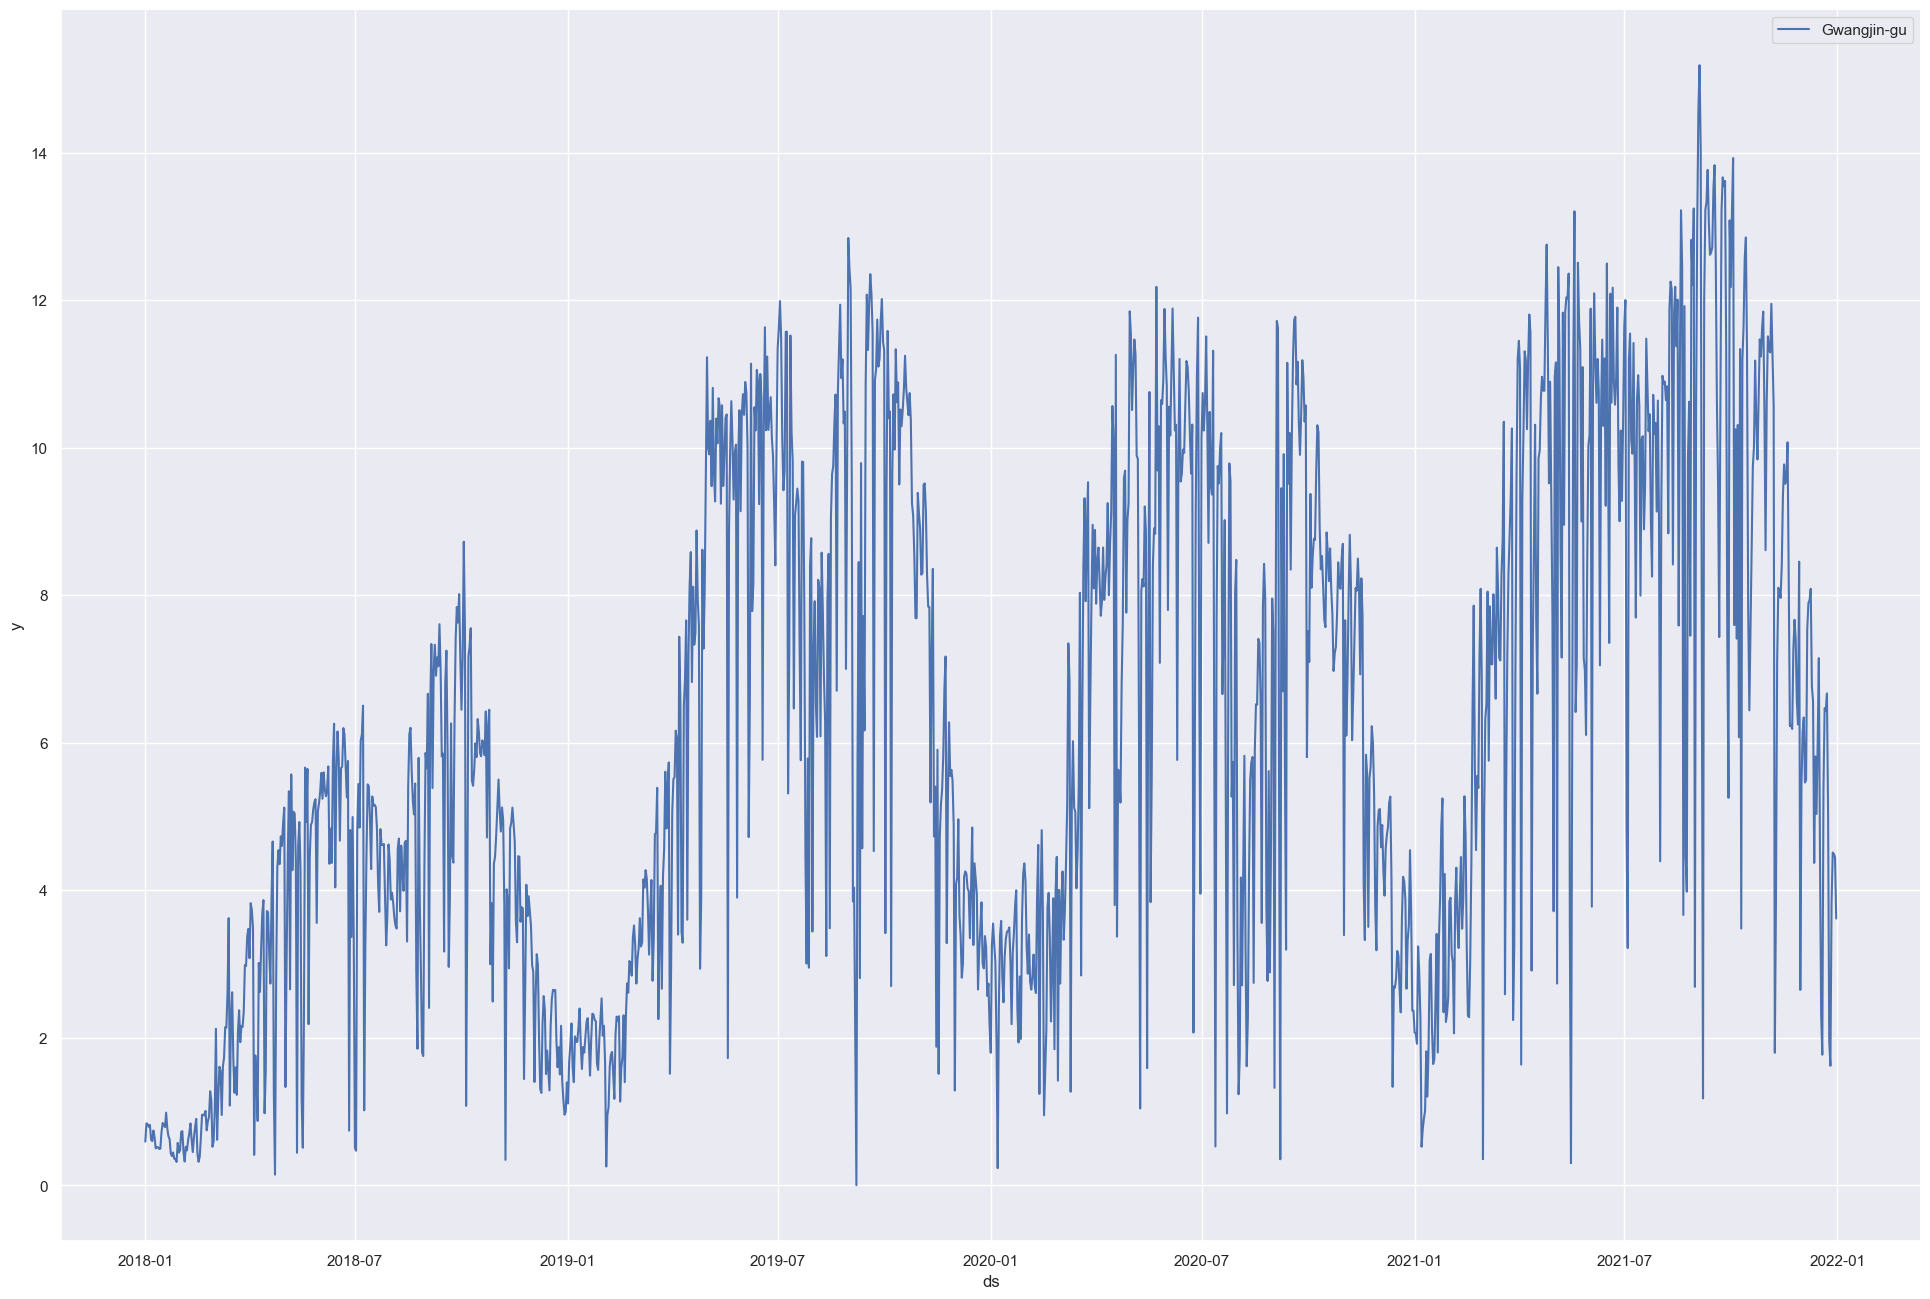

In [28]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(24,16)})
sns.lineplot(x=df_g['ds'], y=df_g['y'])
plt.legend(['Gwangjin-gu'])

## Step 3: Baseline Model Using Default Hyperparameters

In [29]:
# Initiate the model
baseline_model = Prophet()

# Fit the model on the training dataset
baseline_model.fit(df_g)

20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing


#### 참고사항

- Prophet automatically fits daily, weekly, and yearly seasonalities if the time series is more than two cycles long.

<br>

- The model information shows that the yearly seasonality and the daily seasonality are disabled.

<br>

- The daily seasonality is disabled because we do not have sub-daily time series.

<br>

- The yearly seasonality is disabled although we have two years of data because there are no 휴일 및 주말에대한 따릉이 이용량, so we have less than 365 data points for each year. (현재 그렇다는 내용)

<br>
<br>


Next, let’s do **cross-validation** for the baseline model to get the model performance. Prophet has a cross_validation function to automate the comparison between the actual and the predicted values.

    - model=baseline_model 
    specifies the model name.
    
    
    - initial='200 days' 
    means the initial model will be trained on the first 200 days of data.
    
    
    - period='30 days' 
    means 30 days will be added to the training dataset for each additional model.
    
    
    - horizon = '30 days' 
    means that the model forecasts the next 30 days. 

    When only horizon is given, Prophet defaults initial to be triple the horizon, and period to be half of the horizon.
    
    
    - parallel="processes" 
    enables parallel processing for cross-validation. When the parallel cross-validation can be done on a single machine, "processes" provide the highest performance. For larger problems, dask can be used to do cross-validation on multiple machines.
    

In [30]:
# Cross validation
baseline_model_cv = cross_validation(model=baseline_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] done pro

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-07-21,5.419016,4.163579,6.699629,4.098,2018-07-20
1,2018-07-22,5.118414,3.759523,6.468743,3.706,2018-07-20
2,2018-07-23,5.293693,3.996348,6.643331,4.828,2018-07-20
3,2018-07-24,5.294468,4.028116,6.530489,4.614,2018-07-20
4,2018-07-25,5.487051,4.121874,6.702961,4.612,2018-07-20


- Based on the output from the cross-validation, we can get the model performance using the method performance_metrics.

<br>

- The model performance metrics are calculated using a rolling window. The average performance metrics values are calculated for each value of the horizon. Since we have the horizon value of 30 days, there will be 30 average values, one for each day.

<br>

- rolling_window determines the window size, which is the percentage of forecasted data points to include in the calculation.

<br>
<br>

    - rolling_window=0 
    computes performance metrics separately for each horizon.

    - rolling_window=0.1 
    is the default value, which computes performance metrics using about 10% of the predictions in each window.

    - rolling_window=1 
    computes performance metrics using all the forecasted data. We are using rolling_window=1 in this tutorial. to get a single performance metric number.

    - rolling_window<0 
    computes each data point without averaging (i.e., MSE will actually be a squared error with no mean)[3]

In [31]:
# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,30 days,5.908214,2.430682,1.868381,0.226946,0.319571,0.606349


#### Prophet provides six commonly used performance metrics:

- Mean Squared Error(MSE) sums up the squared difference between actual and prediction and is divided by the number of predictions.

<br>

- Root Mean Square Error(RMSE) takes the square root of MSE.

<br>

- Mean Absolute Error(MAE) sums up the absolute difference between actual and prediction and is divided by the number of predictions.

<br>

- Mean Absolute Percentage Error(MAPE) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. **But it’s undefined when the actual value is zero.**

<br>

- Median Absolute Percentage Error(MDAPE) is similar to MAPE. The difference is that it calculates the median instead of taking the average of the absolute percentage difference.

<br>

- Symmetric Mean Absolute Percentage Error(SMAPE) is similar to MAPE. The difference is that when calculating absolute percentage error, the denominator is the actual value for MAPE and the average of the actual and predicted value for SMAPE.

##### We can see that the baseline model using default hyperparameters has 4.45% Mean Absolute Percentage Error (MAPE), meaning that the predictions are 4.45% off the actual values.

In [33]:
# Get the performance metric value
baseline_model_p['mse'].values[0]

5.908213989892626